In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder  
%matplotlib inline

In [2]:
data_dir = "../input/New Plant Diseases Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [3]:
transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
batch_size = 128
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform) 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=0, pin_memory=True)

In [5]:
AlexNet = nn.Sequential(
    # 这里，我们使Q用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过度拟合
    nn.Linear(9216, 2048), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 512), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(512, 38)).cuda()

In [6]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [7]:
AlexNet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=9216, out_features=2048, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=2048, out_features=512, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featur

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet.parameters(), lr=0.008, momentum=0.9)

In [9]:
total_step = len(train_dl)
num_epoch = 20
List_acc_valid=[]
List_acc_train=[]  
List_loss_valid=[]
List_loss_train=[]
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    AlexNet.train()
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 275 == 274:    # print every 1000 mini-batches
            correct_train = 0
            total_train = 0
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            acc_train = 100 * correct_train/total_train
            running_loss = 0.0
            print ('Epoch [{}/{}], Step [{}/{}], Accuracy: {}%, Loss: {:.4f}'.format(epoch+1, num_epoch, i+1, total_step, acc_train, loss.item()))
    
    correct = 0
    total = 0
    AlexNet.eval()
    total_loss_per_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dl):
            images_valid, labels_valid = data[0].to(device), data[1].to(device)
            outputs_valid = AlexNet(images_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            total_loss_per_epoch += loss_valid.item()
            _, predicted = torch.max(outputs_valid.data, 1)
            total += labels_valid.size(0)
            correct += (predicted == labels_valid).sum().item()
            acc_valid = 100 * correct / total
        loss_per_epoch = total_loss_per_epoch/i    
        print('Accuracy: %.2f %%' % (100 * correct / total))
        print(loss_per_epoch)
        
        List_acc_valid.append(acc_valid)
        List_acc_train.append(acc_train)
        List_loss_valid.append(loss_valid.item())
        List_loss_train.append(loss.item()) 
print('Finished Training of AlexNet')

C:\Users\Yueqiao\anaconda3\envs\ttorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/20], Step [275/550], Accuracy: 13.28125%, Loss: 3.2891
Epoch [1/20], Step [550/550], Accuracy: 37.5%, Loss: 2.1492
Accuracy: 46.65 %
1.7665215045431235
Epoch [2/20], Step [275/550], Accuracy: 55.46875%, Loss: 1.3871
Epoch [2/20], Step [550/550], Accuracy: 83.33333333333333%, Loss: 0.6532
Accuracy: 74.12 %
0.8222477646123101
Epoch [3/20], Step [275/550], Accuracy: 81.25%, Loss: 0.6990
Epoch [3/20], Step [550/550], Accuracy: 100.0%, Loss: 0.1679
Accuracy: 85.80 %
0.4567157455930745
Epoch [4/20], Step [275/550], Accuracy: 84.375%, Loss: 0.5194
Epoch [4/20], Step [550/550], Accuracy: 95.83333333333333%, Loss: 0.2224
Accuracy: 90.21 %
0.31005372167870837
Epoch [5/20], Step [275/550], Accuracy: 92.96875%, Loss: 0.2666
Epoch [5/20], Step [550/550], Accuracy: 95.83333333333333%, Loss: 0.1824
Accuracy: 94.00 %
0.18688758538464886
Epoch [6/20], Step [275/550], Accuracy: 93.75%, Loss: 0.1564
Epoch [6/20], Step [550/550], Accuracy: 91.66666666666667%, Loss: 0.2201
Accuracy: 94.22 %
0.1825

In [10]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
classes = ('Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus')

In [12]:
class_correct = list(0. for i in range(38))
class_total = list(0. for i in range(38))
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(36):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            


for i in range(38):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Apple___Apple_scab : 100 %
Accuracy of Apple___Black_rot : 99 %
Accuracy of Apple___Cedar_apple_rust : 96 %
Accuracy of Apple___healthy : 98 %
Accuracy of Blueberry___healthy : 96 %
Accuracy of Cherry_(including_sour)___healthy : 98 %
Accuracy of Cherry_(including_sour)___Powdery_mildew : 100 %
Accuracy of Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 85 %
Accuracy of Corn_(maize)___Common_rust_ : 97 %
Accuracy of Corn_(maize)___healthy : 96 %
Accuracy of Corn_(maize)___Northern_Leaf_Blight : 100 %
Accuracy of Grape___Black_rot : 97 %
Accuracy of Grape___Esca_(Black_Measles) : 99 %
Accuracy of Grape___healthy : 100 %
Accuracy of Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 100 %
Accuracy of Orange___Haunglongbing_(Citrus_greening) : 100 %
Accuracy of Peach___Bacterial_spot : 92 %
Accuracy of Peach___healthy : 100 %
Accuracy of Pepper,_bell___Bacterial_spot : 98 %
Accuracy of Pepper,_bell___healthy : 88 %
Accuracy of Potato___Early_blight : 100 %
Accuracy of Potato___

In [15]:
PATH = './plant38_AlexNet_full.pth'
torch.save(AlexNet, PATH)

 Accuracy for train dataset:100.00%
 Accuracy for valid dataset:97.24%




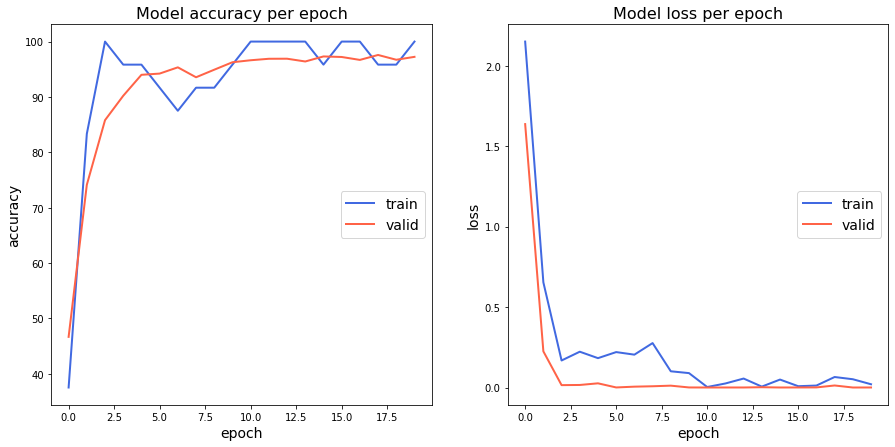

In [13]:

print('\033[1m Accuracy for train dataset:{:.2f}%\033[0m'.format(List_acc_train[-1]))
print('\033[1m Accuracy for valid dataset:{:.2f}%\033[0m'.format(List_acc_valid[-1]))
print('\n')

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(List_acc_train,"royalblue",linewidth=2)
plt.plot(List_acc_valid,"tomato",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)

plt.subplot(122)
plt.plot(List_loss_train,"royalblue",linewidth=2)
plt.plot(List_loss_valid,"tomato",linewidth=2)
plt.title('Model loss per epoch',fontsize=16)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)
plt.show()

In [1]:
PATH = './plant38_AlexNet_full.pth'
model = torch.load(PATH)

NameError: name 'torch' is not defined